In [53]:
import socket
import pandas as pd
import numpy as np
import skrf as rf
from skrf.calibration import Open
import matplotlib.pyplot as plt

In [54]:
filename = 'test'
data_points = 1001

# Converting binary data

In [55]:
def to_little_endian(paquets):
    little_endian_paquets = []
    for paquet in paquets:
        # Divide into 1 byte list
        octets = [paquet[i:i+2] for i in range(0, len(paquet), 2)]
        # Invert order
        little_endian_paquet = ''.join(octets[::-1])
        little_endian_paquets.append(little_endian_paquet)
    return little_endian_paquets

#For little endian raw data frequency convertion
def to_decimal(little_endian_paquets):
    decimal_values = []
    for paquet in little_endian_paquets:
        # Convert into decimal
        decimal_value = int(paquet, 16)
        decimal_values.append(decimal_value)
    return decimal_values

#For little endian raw data Real/Imag convertion
#Use only the first 20 bits
def to_decimal_20bits(little_endian_paquets):
    decimal_values = []
    for paquet in little_endian_paquets:
        decimal_value = int(paquet[3:], 16)
        if(paquet[2] == 'f'):
            #Re/Im(s) is negative
            decimal_value = decimal_value - 1048576
        decimal_value = decimal_value/1000000
        decimal_values.append(decimal_value)
    return decimal_values

def S_to_Z(S_real, S_imag, Z0=50):
    """ Calculate the real and imaginary impedance from S-parameters. 
    :param S_real: List of the real parts of the S-parameters. 
    :param S_imag: List of the imaginary parts of the S-parameters. 
    :param Z0: Characteristic impedance (default is 50 ohms). 
    :return: Tuple containing the real and imaginary parts of the impedance. """
        
    S = np.array(S_real) + 1j * np.array(S_imag)

    Z = Z0 * (1 + S) / (1 - S)

    Z_real = Z.real
    Z_imag = Z.imag

    return Z_real, Z_imag

# Delete 7d appearance

In [56]:
def remove_7d(input_file):
    with open(input_file, 'rb') as f:
        data = f.read()

    corrected_data = data.replace(b'\x7d', b'')

    output_file = 'corrected_' + input_file

    with open(output_file, 'wb') as f:
        f.write(corrected_data)

# Decode file

In [57]:
#Binary data are:
#S-parameters
#Each parameters appears the number of points set on the VNA : 126, 251, 501, 1001
#After the header (@0x222) => frequencies are coded on 4 bytes, big endian, in 10th of kHz. e.g 500 is 5 MHz
#After is S-parameter real part (@0x4548), coded on 4 bytes, big endian, with 12b LSB (in big endian raw data) being either 00 0 or FF F. FF F is for negative values (subtract 1048576)
#After is imaginary part (@0x8552). Same coding as real part.
#Then trailer
#To be understood : 
##If a bytes is 5F or 5E (or simply 5x, tbc), there's a leading 7D before. Giving 7D 5x. 7D has to be removed.
##For frequencies, there's also a 7E7F to remove
##For frequencies, seems like 7d 5d is 7d

def decode_file(filename):
    #need to count the 7d5 skip to keep alignement of data
    skip_7d5 = 0

    with open(filename + '.bin', 'rb') as fichier:

        i = 0
        while(fichier.tell() <= 546):
            data = fichier.read(4)
            hex_data = data.hex()
            if '7d5' in hex_data:
                i += 1
                #print(str(i) + " " + str(fichier.tell()))
            if len(hex_data) < 4:
                break


    ####     FREQUENCY    #####
        fichier.seek(544)
        frequencies = []
        i = 0
        while(len(frequencies) != data_points):
            data = fichier.read(4)
            hex_data = data.hex()
            if len(hex_data) < 4:
                break
            #frequencies.append(frequency.hex())
            if '7d5' in hex_data:#To be understood
                #skip byte 7d
                hex_data = hex_data.replace('7d', '', 1)
                extra_data = fichier.read(1)
                hex_data += extra_data.hex()
                skip_7d5 += 1
                print("freq skip")
            if '7e7f' in hex_data:#To be understood
                #skip next 3 bytes
                fichier.read(3)
            else :
                frequencies.append(hex_data)
            i += 1

    ####     REAL    #####
        fichier.seek(4548)
        real = []
        while(len(real) != data_points):
            data = fichier.read(4)
            hex_data = data.hex()
            if len(data) < 4:
                break

            while '7d5' in hex_data:#To be understood
                #skip byte 7d
                hex_data = hex_data.replace('7d', '', 1)
                extra_data = fichier.read(1)
                skip_7d5 += 1
                #print("real skip")
                if len(extra_data) < 1:
                    break
                hex_data += extra_data.hex()
            real.append(hex_data)


    ####     IMAGINARY    #####
        fichier.seek(8552 + skip_7d5)
            
        imag = []
        while(len(imag) != data_points):
            data = fichier.read(4)
            hex_data = data.hex()
            if len(data) < 4:
                break

            while '7d5' in hex_data:#To be understood
                #skip byte 7d
                hex_data = hex_data.replace('7d', '', 1)
                extra_data = fichier.read(1)
                #print("imag skip")
                if len(extra_data) < 1:
                    break
                hex_data += extra_data.hex()
            imag.append(hex_data)

    #print(frequencies)
    little_endian_paquets = to_little_endian(frequencies)
    dec_frequencies = to_decimal(little_endian_paquets)
    dec_frequencies = [freq / 100 for freq in dec_frequencies]
    #print(dec_frequencies)

    #print(real)
    little_endian_paquets = to_little_endian(real)
    dec_real = to_decimal_20bits(little_endian_paquets)
    #print(dec_real)

    #print(imag)
    little_endian_paquets = to_little_endian(imag)
    dec_imag = to_decimal_20bits(little_endian_paquets)
    #print(dec_imag)

    Z_real, Z_imag = S_to_Z(dec_real, dec_imag)

    df = pd.DataFrame({
        'Raw frequency' : frequencies,
        'frequencies': dec_frequencies,
        'Real raw packet' : real,
        'S-real': dec_real,
        'Imag raw packet' : imag,
        'S-imag' : dec_imag,
        'Z-real' : Z_real,
        'Z-imag' : Z_imag
    })

    df.to_csv('output.csv', index=False)
    
    return dec_frequencies, dec_real, dec_imag

# Get data

In [58]:
def send_hex_data_and_receive(ip, port, hex_data, timeout=5):
    data = bytes.fromhex(hex_data)
    
    # Create TCP/IP socket
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        try:
            s.connect((ip, port))
            #print(f"Connecté à {ip} sur le port {port}")

            s.sendall(data)
            #print(f"Données envoyées: {hex_data}")

            s.settimeout(timeout)

            total_data = b''
            with open(filename + '.bin', 'wb') as file:
                while True:
                    try:
                        response = b''
                        response = s.recv(1050)
                        if not response:
                            break
                        total_data += response
                        #print(f"Paquet reçu de {len(response)} bytes, {response[len(response)-2]} . {response[len(response)-1]}")
                        #print(f"Réponse complète reçue: {response.decode('ascii', errors='ignore')}")

                        file.write(response[5:len(response)-2])
                        #file.write(response)
                        #Skip first 5 bytes
                        #Format : 7d 53 11 0d xx
                        #xx is packet number
                        #Skip last 2 bytes
                    except socket.timeout:
                        #print("Timeout atteint, fin de la réception des données.")
                        file.close()
                        break

        except Exception as e:
            print(f"Error : {e}")
        finally:
            try:
                s.close()
            except Exception as e:
                print(f"Error while closing socket: {e}")

Data were written intest.s1p


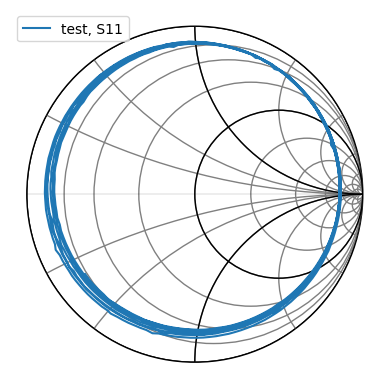

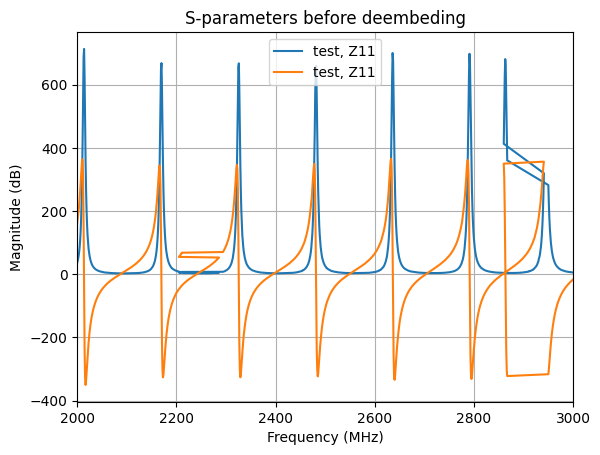

In [59]:
# Connection parameters
ip_address = '192.168.1.38'
port_number = 66
Hello = '7F 41 50 01 00 92 7e'
Get_smith = '7f 41 11 01 00 64 65 66 61 75\
6c 74 2e 74 72 61 00 8f 54 18 1d 90 54 18 1d 50\
82 16 1d 00 00 e3 1b 00 00 00 00 fc ec 55 07 46\
f1 a1 77 00 00 00 00 00 00 00 00 00 00 00 00 88\
f3 55 07 90 54 18 1d 00 00 00 00 48 ed 55 07 1b\
3c 0f 75 00 00 e3 1b 00 00 00 00 3a 3c 0f 75 89\
5a 5a 01 88 f3 55 07 e0 55 5c 00 00 00 00 00 88\
f3 55 07 88 f3 55 07 00 00 00 00 46 10 2b 00 10\
ed 55 07 d7 8a c6 76 14 ee 55 07 00 00 00 00 f1\
7e'

for i in range(1):
    send_hex_data_and_receive(ip_address, port_number, Get_smith)
    remove_7d(filename + '.bin')
    dec_frequencies, dec_real, dec_imag = decode_file('corrected_' + filename)
    
    # Init touchstone header
    touchstone_lines = [
        "! Converted from CSV to Touchstone format",
        "# MHz S RI R 50"
    ]

    # Add data to touchstone
    for freq, real, imag in zip(dec_frequencies, dec_real, dec_imag):
        line = f"{freq:.6f} {real:.6f} {imag:.6f}"
        touchstone_lines.append(line)

    # Write touchstone
    with open(filename + ".s1p", "w") as file:
        for line in touchstone_lines:
            file.write(line + "\n")

    print("Data were written in" + filename + ".s1p")

    ntwk = rf.Network(filename + ".s1p")
    ntwk.plot_s_smith()
    plt.figure()
    #ntwk.plot_s_db(m=0, n=0)
    #ntwk.plot_s_deg()

    ntwk.plot_z_re()
    ntwk.plot_z_im()
    
    plt.title('S-parameters before deembeding')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.show()

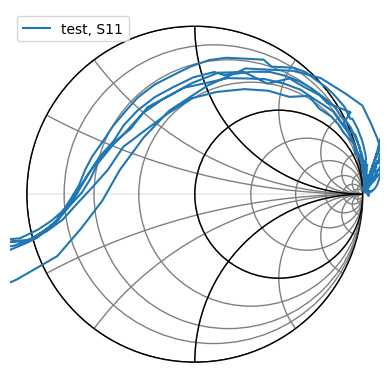

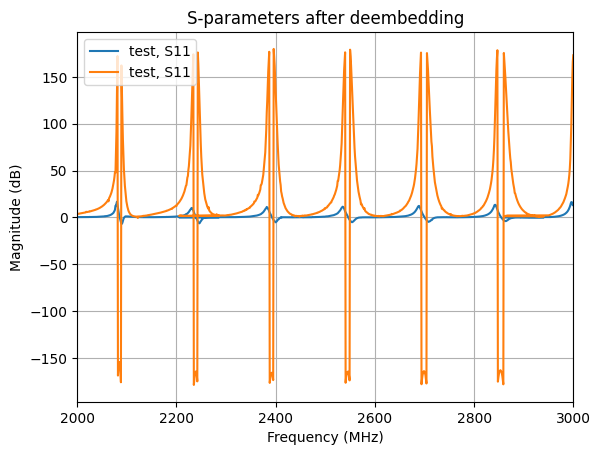

In [60]:
op = rf.Network('deembed.s1p')
dm = Open(dummy_open = op, name = 'test_open')

realdut = dm.deembed(ntwk)

realdut.plot_s_smith()

plt.figure()
realdut.plot_s_db(m=0, n=0)
realdut.plot_s_deg()

plt.title('S-parameters after deembedding')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()
